# <center>機械学習 第6回 「Pythonによる重回帰」</center>
<center>2024年月5日21　瀧雅人</center>

### 目標

scikit-learnを使った重回帰分析に慣れる。Pandasをデータの前処理に使え利用になる。正則化を用いた特徴量選択や、多項式回帰の使い方を覚える

# <center>scikit-learnによる重回帰</center>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# 1 Auto MPG データ

今回扱うデータ

https://archive.ics.uci.edu/ml/datasets/auto+mpg

はTensorFlowの回帰チュートリアルでも使われているデータです。これを車の燃費を予測するタスクに使いましょう。重回帰で十分分析できます。


全部で8+1個の属性、計389インスタンスが含まれます。

さてこのデータをダウンロードしましょう。実はColaboratoryも、その実態はLinux（Ubuntu）マシンです：

In [ ]:
!uname -a

Linux 1f0da9bee610 5.15.107+ #1 SMP Sat Apr 29 09:15:28 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


（Colab上では普通のシェルと違い、コマンドの前に`!`をつけます）ですので、基本的なLinuxマシンの操作方法をわかっていれば色々と操作できます。ダウンロードもその一例です。

ではこのデータをカレントディレクトリ

In [ ]:
!pwd

/content


（ルート直下の`content`というディレクトリ）にダウンロードしましょう：

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data

--2024-05-20 13:27:57--  https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘auto-mpg.data’

auto-mpg.data           [ <=>                ]  29.58K  --.-KB/s    in 0.008s  

2024-05-20 13:27:57 (3.48 MB/s) - ‘auto-mpg.data’ saved [30286]



きちんとデータ（`auto-mpg.data`）がダウンロードされています：

In [ ]:
!ls

auto-mpg.data  sample_data



---


## 必須事項

コマンドやCLI（コマンドラインインターフェイス）に慣れて、Colabや研究活動でも活用しましょう。

---


Google Driveをマウントして、Drive側にデータを保存しても構いません。その際には、下のセルでデータを読み込む際のパスを（単回帰実装の際のコードを参考に）書き換えてください。

## 1.1 データのロードと確認

このデータには、車に関する9個の属性を持つデータが収められている：

| 属性名 | 意味・単位 |
| :--- | :---: |
| MPG | 燃費 [miles per gallon] |
| Cylinders | エンジンの気筒数。3,4,5,6,8のいずれか。  |
| Displacement | 排気|
| Horsepower | 馬力|
| Weight | 重量|
| Acceleration | 加速|
| Model Year | 西暦の下二桁[年]。70〜82の整数。|
| Origin | 1(アメリカ製)、2(ヨーロッパ製)、3(アジアかそれ以外の地域製)のいずれか。|
| Car Name | 文字列|

このデータの属性`MPG`は車の燃費を表す。そこで今回は、この燃費を予測する問題を考えてみましょう。

今回のデータは、Pandasの`read_csv()`を使ってみましょう。
このデータを`pd.read_csv()`で読み込む際には、次の引数を与えなくてはいけない点に気をつけましょう：

- `column_names=[各列(属性)の名前]`

- `delim_whitespace=True`：各行の要素がカンマではなく、<b>空白</b>（whitespace）で区切られている

- `na_values='?'`：欠損値は`'?'`という文字列で表記されている



では、さっそくデータを読み込みましょう：

In [ ]:
column_names = ['MPG', 'Cylinders', 'Displacement',
                'Horsepower', 'Weight', 'Acceleration',
                'Model Year', 'Origin', 'Car Name']

df = pd.read_csv('./auto-mpg.data',
                 names=column_names, na_values='?', delim_whitespace=True)

Pandasを使うことで、DataFrameというオブジェクトとしてデータを読み込むことができました。

`.head()`を使って、先頭の5個のインスタンスだけを取り出してみますと

In [ ]:
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Car Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


これら9個の属性について欠損値が無いか、データフレームの`.info()`でチェックしてみます：

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
 8   Car Name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


398個のインスタンスがありますが、Horsepowerには6個の欠損が見られます。

## 1.2 データの前処理

### ① Car Name 属性の処理

簡単な言語処理や外部データを使って、同じ会社の製品・似た車名のインスタンスには、類似の属性を与えることも可能でしょう。
ただここではそれは本題ではないので、Car Nameの列は単純に削除します：

In [ ]:
df = df.drop('Car Name', axis=1)



---


## 自由研究

Car Name属性をうまく使う方法を考えてみましょう。


---



### ② 欠損値の処理

先ほど見つけた欠損値は、次のようにカウントすることもできます：

In [ ]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

このHorsepower属性の欠損値6個の処理を考えてみます。

In [ ]:
df.describe()['Horsepower']

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: Horsepower, dtype: float64

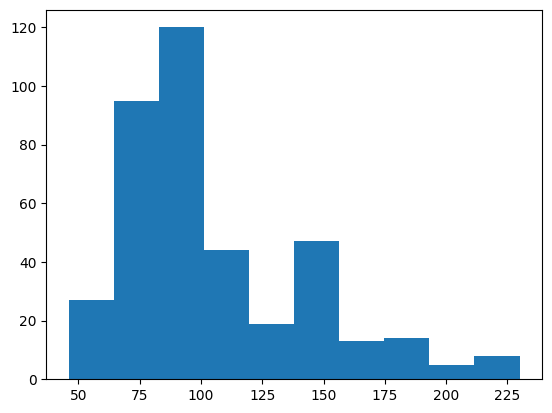

In [ ]:
hp = df['Horsepower'] # Horsepower属性だけを取り出す
hp = hp.dropna() # 欠損値nanを除外
hp = hp.tolist() # DataFrameをリストに変換

plt.hist(hp)
plt.show()

tailが長い分布であることが若干気になるが、多くの値は平均値周りに集まっている。そこで今回は単純に、欠損値を<b>属性平均値で埋める</b>ことにする。


DataFrameを使って欠損値を埋めるには`fillna()`メソッドを用いる：

In [ ]:
df_mean = df.mean() # 各属性の平均値

df_filled = df.fillna(df_mean) # 各属性をそれぞれの平均値で埋める

In [ ]:
df_mean

MPG               23.514573
Cylinders          5.454774
Displacement     193.425879
Horsepower       104.469388
Weight          2970.424623
Acceleration      15.568090
Model Year        76.010050
Origin             1.572864
dtype: float64

### 欠損に関する補遺＊

一応、欠損を含むインスタンスの分布に偏りがないかをざっと確認する。ランダムに生じていない欠損値の処理には特別の注意が必要だからである。

欠損値を含む6行だけ取り出すと、その統計量は

In [ ]:
dfna = df.loc[df.isna().any(axis=1)==True,:]
dfna.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,6.000000,6.000000,6.00000,0.0,6.000000,6.000000,6.000000,6.000000
mean,28.000000,4.333333,129.00000,NaN,2502.666667,17.316667,78.000000,1.333333
std,7.886951,0.816497,43.32205,NaN,504.296209,2.212163,4.427189,0.516398
min,21.000000,4.000000,85.00000,NaN,1835.000000,14.300000,71.000000,1.000000
25%,23.150000,4.000000,98.50000,NaN,2114.500000,16.100000,75.500000,1.000000
50%,24.300000,4.000000,120.00000,NaN,2597.500000,17.150000,80.000000,1.000000
75%,32.125000,4.000000,148.25000,NaN,2897.500000,18.575000,80.750000,1.750000
max,40.900000,6.000000,200.00000,NaN,3035.000000,20.500000,82.000000,2.000000


であり、データ全体と比べてもそこまで気になるズレは見当たらない

In [ ]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


6個しかないしバイアスも大きくはないならば、行ごと捨てても良い。



---


## 必須事項

テスト・訓練の分割前にこの処理をしていることに注意。<b>欠損値の処理は分割後の方が良いか</b>、など、色々考察してみましょう。


---



### ③ カテゴリカル属性の処理

Originは**順序カテゴリカル変数ではない**。したがってダミー変数へのエンコーディングを行う。

定番は**one-hotエンコーディング**である。one-hotでは、属性Origin=1,2,3から三つのバイナリ属性Origin_1, Origin_2, Origin_3を作る。これら新しい属性の値は、元の属性と次のように対応している：

カテゴリ1　→　(1,0,0)

カテゴリ2　→　(0,1,0)

カテゴリ3　→　(0,0,1)

ただしこのように作ったone-hotの3属性は、互いに強い相関を持つ変数だ（足したら必ず１）。

そこで**多重共線性**が生じることを気にして、引数`drop_first=True`により三つの属性から始めのもの(Origin_1)を落として二個だけ使おう：

In [ ]:
df_filled = pd.get_dummies(df_filled, columns=['Origin'], drop_first=True)

df_filled.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin_2,Origin_3
0,18.0,8,307.0,130.0,3504.0,12.0,70,False,False
1,15.0,8,350.0,165.0,3693.0,11.5,70,False,False
2,18.0,8,318.0,150.0,3436.0,11.0,70,False,False
3,16.0,8,304.0,150.0,3433.0,12.0,70,False,False
4,17.0,8,302.0,140.0,3449.0,10.5,70,False,False


### ④ 入・出力データの準備とデータ分割

さて前処理が大体終わったので、df_filledからデータなどを切り出そう。

今回のタスクは燃費予測なので、'MPG'属性が出力変数yである。そこで始めの列と、'Cylinders'以降の列に分けて、それぞれをy, Xにする：

In [ ]:
X = df_filled.loc[:,'Cylinders':]
y = df_filled.loc[:,'MPG']

全体のうち、２割をテスト用に残すことにする：

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.3 データの可視化

訓練データが切り出せたので、**訓練データを**可視化したり、その記述統計量を計算することで、学習前に事前分析を行う。それにより分析のヒントやデータの注意点について示唆が得られないかを考える。

まずは<b>ペアプロット</b>を作る。そのためにSeabornというライブラリ（Matplotlibのラッパー）を使う。

ペアプロットは、二つの特徴量の相関具合を見るための散布図の集合である。その対角線には、特徴量のヒストグラムが表示される。ここでは４つの属性に絞って可視化しましょう：

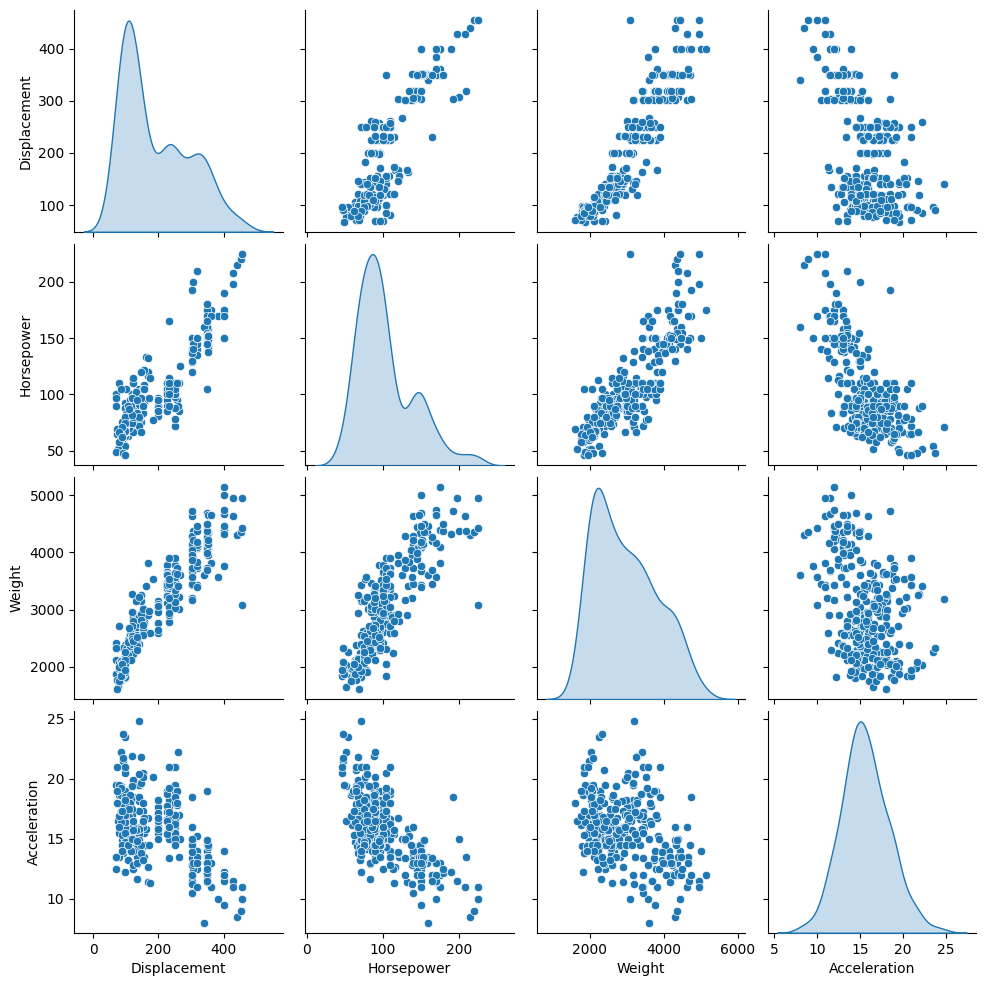

In [ ]:
import seaborn as sns

sns.pairplot(X_train[['Displacement','Horsepower','Weight','Acceleration']], diag_kind="kde")

<b>相関が強い変数が多い</b>ので、学習後の結果の解釈では後々注意する必要がありそうだ。



---


## 自由研究（宿題として最後に再録）

それぞれの属性の相関を計算し、共線性が気になる程度かどうか調べてみよ。場合によっては変数を削除せよ。

多重共線性についてはどうか？分散拡大要因VIFについて調べて、評価してみよ。


---




また分布が若干歪んでいるが、長いテールはないのでそのまま使うことにする
（一般には<b>ボックス-コックス変換</b>を行う方が良い）。

次に、各属性と出力変数との間の相関具合も確認しよう。それぞれの変数が、すでにある程度燃費を説明していることが見て取れる：


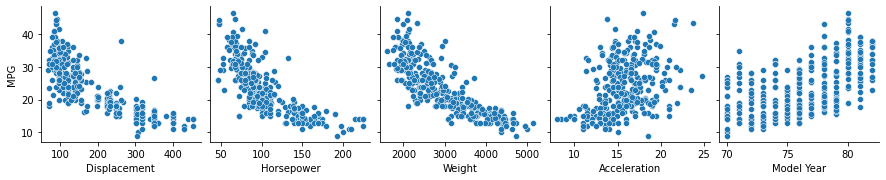

In [ ]:
sns.pairplot(data=pd.concat([y_train, X_train], axis=1), y_vars=['MPG'], x_vars=['Displacement','Horsepower','Weight','Acceleration','Model Year'])

# 2 線形重回帰モデルによる学習


## 2.1 sklearnによる学習

データのチェックが終わったので、検証データも切り出しておく：

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

あとは単回帰と全く同じ流れで重回帰できる。



まずはデータのスケール変換を行う：

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

**単回帰と同じ`SGDRegressor`を使えば、重回帰も実装できる**！これは属性数$P$が幾つであろうと、重回帰のモデルは同じ配列の式でかけるから、$P=1$であろうと$P=9$であろうと、全て同じモデルであるためである。

そこで`SGDRegressor`のインスタンスを作り、`fit()`で学習させよう：

In [ ]:
from sklearn.linear_model import SGDRegressor

reg = SGDRegressor(max_iter=5000, eta0=0.1)
reg.fit(X_train_scaled, y_train)

print('train score:', reg.score(X_train_scaled, y_train))

train score: 0.8087933802759457


各属性の学習された係数は、

In [ ]:
attributes = ['Cylinders','Displacement','Horsepower',
              'Weight','Acceleration','Model Year',
              'Origin2','Origin3']

for a,c in zip(attributes, reg.coef_):
    # cの小数点以下４桁目までprintする
    print('coef of '+a,':', '{:.4f}'.format(c))

coef of Cylinders : -0.1460
coef of Displacement : -1.1726
coef of Horsepower : -1.7384
coef of Weight : -16.7396
coef of Acceleration : 0.7429
coef of Model Year : 9.9880
coef of Origin2 : 2.4027
coef of Origin3 : 2.0002


この学習結果をある程度信じると、

- Model Yearの係数は正で大きい → 新しいモデルほど燃費が良い（Model Yearが大きいほど、燃費も大きい）

- Weightの係数は負で大きい → 重いほど燃費が悪い

など、大雑把には自然な結果が得られている。各属性をスケーリングしていない時は、係数の大きさを比較してあれこれ議論できないことに注意しましょう。





---

## Pythonクイズ

上のコードの仕組みを調べて理解しましょう。

- `zip`はどんな役割をしているでしょう？

- 例えばprint('{:.4f}'.format(1.41421356))はどのような結果を与えるでしょう？


---


## 2.2 学習率に関してグリッドサーチ

学習率`eta0`として、$2^{-20},2^{-19},\cdots,2^{-2},2^{-1},2^{0},2^{1},2^{2}$の範囲で学習させて調べ、ベストな学習率の選び方を探して見る。選択の基準は<b>検証スコア</b>である

まず検証データもスケール変換しておく：

In [ ]:
X_val_scaled = scaler.transform(X_val)

In [ ]:
eta0s = [2**i for i in range(-20,3)] # 学習率のリスト。リスト内包表記を使用。
best_score = -np.inf # ベストなスコア。初期値はマイナス無限大にしておく

score_val_list = list() # 検証スコアを貯めるリスト
best_eta0 = None # ベストな学習率

for eta0 in eta0s:
    # 毎回モデルを作り直し学習
    reg = SGDRegressor(max_iter=10000, eta0=eta0)
    reg.fit(X_train_scaled, y_train)
    # 検証スコア
    score_val = reg.score(X_val_scaled, y_val)
    score_val_list.append(score_val)
    # ベストを更新するかチェック
    if best_score<score_val:
        # ベストの記録を更新
        best_score = score_val
        best_eta0 = eta0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stocha



---
## Pythonクイズ

- リスト内包表記とは何か？（Pyhonicなコードを書くには必須）

- 上のコードで`best_score`の初期値を$-\infty$としている理由は？

---




学習率があまりに小さいと収束せず、検証性能も低い。ある程度大きな学習率ではそれほど性能は変わらない：

Text(0, 0.5, 'val score')

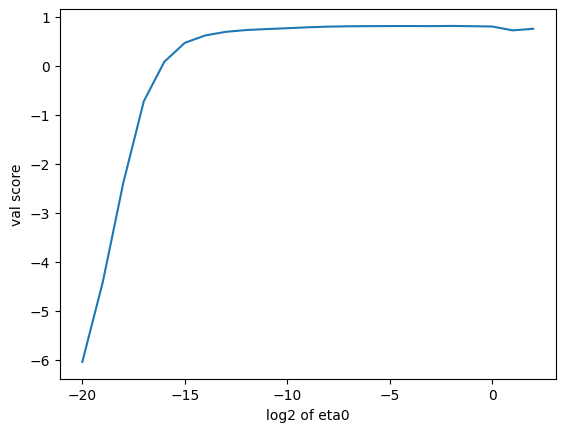

In [ ]:
plt.plot(np.log2(eta0s), score_val_list)
plt.xlabel('log2 of eta0')
plt.ylabel('val score')

In [ ]:
print('best val score:', best_score)
print('best eta:', best_eta0)

best val score: 0.8143784357831068
best eta: 0.25


- グリッドサーチをよりよく行うための`sklearn.model_selection.GridSearchCV`の使い方も後に学ぶ

- 早期終了による正則化を使うことも考えるといい

## 2.3 残差プロット

とりあえず学習率0.5のモデルを考えよう：

In [ ]:
reg = SGDRegressor(max_iter=5000, eta0=0.5)
reg.fit(X_train_scaled, y_train)

SGDRegressor(eta0=0.5, max_iter=5000)

デフォルトで、すでに$L_2$正則化が入っている（`penalty='l2'`）ことに注意しましょう。

実際の出力と予測の差を**残差**といいます（インスタンスごとの誤差）

$$
e_n=y_n-{\hat{y}}(x_n)
$$

これをプロットすることで、どれほどモデルが当てはまっていないかがわかる。

横軸に予測値、縦軸に残差をとって実際にプロットして見る

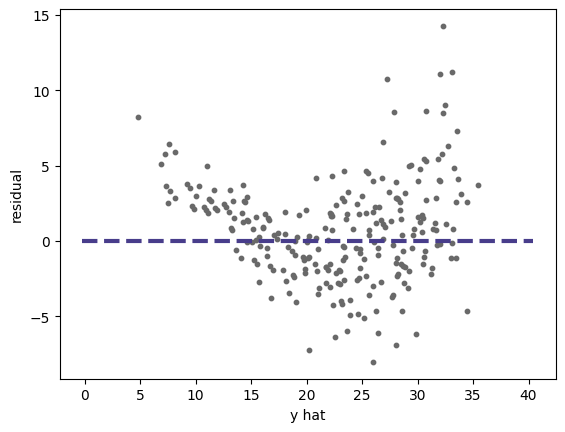

In [ ]:
y_hat = reg.predict(X_train_scaled)
residual = y_train - y_hat

plt.scatter(y_hat, residual, c='dimgray', s=10)
plt.hlines([0], np.min(y_hat)-5, np.max(y_hat)+5, 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel('y hat')
plt.ylabel('residual')
plt.show()

残差は0を中心に自然に分布しているわけではなく、属性の値により分布の様子が大きく変わってしまう（平均も分散も）。これはモデルの当てはまりの良さ・悪さが属性軸に対して均一なわけではなく、属性の数値スケールによって当てはまり具合が変化してしまっていることを意味する。


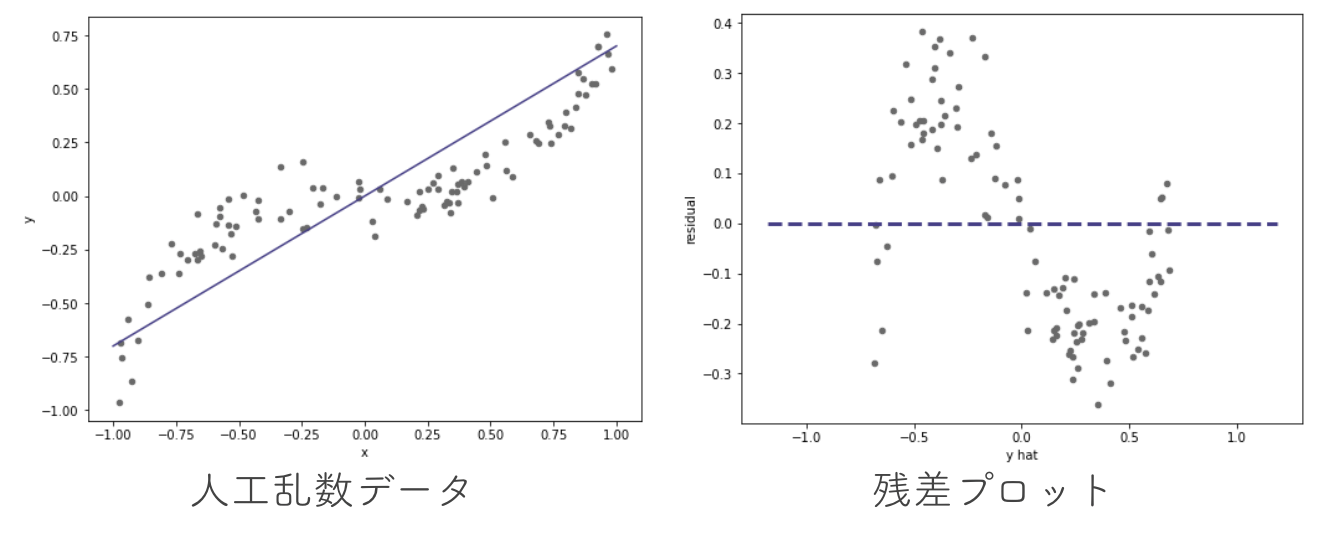

つまり、残差に強い非線型性がある。言い換えると線形回帰では捉えきれない非直線的な構造があり、**多項式回帰を使った方が良いであろう**と考えられる。

以下で属性ごとの残差プロットも見ておく。


残差プロットにおいては横軸は属性$x_{ni}$に選ぶが、縦軸には残差ではなく
$e_n+{\hat{a}}{}_ix_{ni}$の値をとった<b>偏残差プロット</b>を使う場合もある。

### Displacement属性の残差プロット

Text(0, 0.5, 'residual')

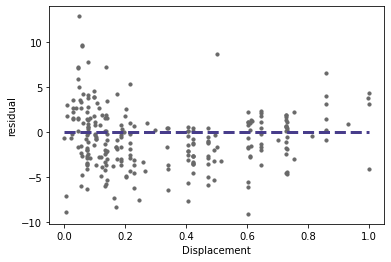

In [ ]:
idx = 1
plt.scatter(X_train_scaled[:,idx],residual, c='dimgray', s=10)
plt.hlines([0], np.min(X_train_scaled[:,idx]), np.max(X_train_scaled[:,idx]), 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel(attributes[idx])
plt.ylabel('residual')

### Horsepower属性の残差プロット

Text(0, 0.5, 'residual')

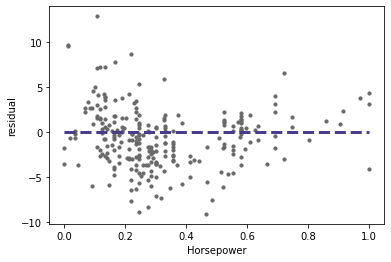

In [ ]:
idx = 2
plt.scatter(X_train_scaled[:,idx],residual, c='dimgray', s=10)
plt.hlines([0], np.min(X_train_scaled[:,idx]), np.max(X_train_scaled[:,idx]), 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel(attributes[idx])
plt.ylabel('residual')

### Weight属性の残差プロット

Text(0, 0.5, 'residual')

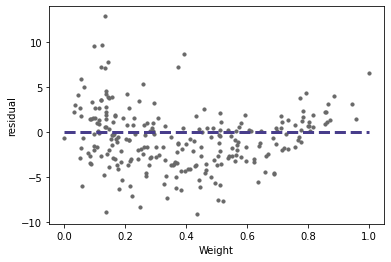

In [ ]:
idx = 3
plt.scatter(X_train_scaled[:,idx],residual, c='dimgray', s=10)
plt.hlines([0], np.min(X_train_scaled[:,idx]), np.max(X_train_scaled[:,idx]), 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel(attributes[idx])
plt.ylabel('residual')

### Acceleration属性の残差プロット

Text(0, 0.5, 'residual')

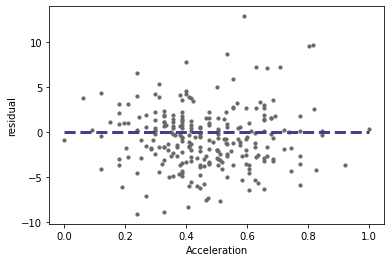

In [ ]:
idx = 4
plt.scatter(X_train_scaled[:,idx],residual, c='dimgray', s=10)
plt.hlines([0], np.min(X_train_scaled[:,idx]), np.max(X_train_scaled[:,idx]), 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel(attributes[idx])
plt.ylabel('residual')

## 2.4 Q-Qプロット＊

残差が正規分布している、という**回帰分析・検定に関する仮定**を確認しよう（通常はデータサイエンスの分析項目はこの仮定に依拠したものを使うことは少ない、と言われるが。しかし普通の統計分析も行う場合は注意）。この辺りの正規性に関しては、回帰分析ユーザーでも理解していない・勘違いしている人が多いので、関心のある人は自分できちんと勉強してみよう（統計学）。

Q-Qプロットというグラフは、残差の分布が正規分布に近いほど点が直線上に乗るようなプロットである。実際に今回の結果のQ-Qプロットを見てみよう：

In [ ]:
import scipy.stats as stats

stats.probplot(residual, dist="norm", plot=plt)
plt.show()

## たまにある間違った理解＊

以上は残差の話である。しばしば誤って解説されているが、**属性自体は正規分布している必要はない**！

属性を**Box-Cox変換**等で綺麗な分布に近づけるのは、
残差を分散均一性に近づけるためである。
また学習においてロングテールは悪さをするため、分布のテールを縮小する役割もある。

しつこいが、これらは属性自体の正規性とは別の話である。

# 3 多項式回帰

## 3.1 ２次多項式特徴量の作成

`PolynomialFeatures`を使って、多項式特徴量の計画行列`X_train_poly`へまずは変換：

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False).fit(X_train_scaled)
X_train_poly = poly.transform(X_train_scaled)

$x_1,x_2,\cdots,x_8$の８属性からなる計画行列から、$x_1,(x_1)^2,x_1x_2,x_2,\cdots,(x_8)^2$とたくさんの属性を持つ計画行列が得られた:


$$
X=
\begin{pmatrix}
x_1&x_2&\cdots&x_8\\
\vdots&\vdots&&\vdots
\end{pmatrix}
\longrightarrow
\begin{pmatrix}
x_1&x_2&\cdots&x_8
&(x_1)^2&x_1x_2&\cdots&(x_8)^2
\\
\vdots&\vdots&&&&&&\vdots
\end{pmatrix}
$$



この多項式属性を含んだ新しい計画行列を重回帰することで、多項式回帰を実装しよう：

In [ ]:
reg = SGDRegressor(max_iter=5000, eta0=0.1)
reg.fit(X_train_poly, y_train)

print('train score:', reg.score(X_train_poly, y_train))

train score: 0.8647153410504982


検証スコアは

In [ ]:
X_val_poly = poly.transform(X_val_scaled)
print('val score:', reg.score(X_val_poly, y_val))

val score: 0.8446635482575535


先ほどよりもスコアが向上。

次の関数を使って、**寄与の大きいtop10の属性とその係数を表示**して見る：

In [ ]:
def power2attribute(pows, attribs):
    str_list = []
    for i, p in enumerate(pows):
        if p!=0:
            str_list.append('('+attribs[i]+')**'+str(p))
    return ' * '.join(str_list)

def get_top10_feature_names(pows, attribs, model):
    print('feature name',':','coefficient')
    print('-'*50)
    idxs = np.argsort(np.abs(model.coef_))[-10:][::-1]
    for idx in idxs:
        name = power2attribute(pows[idx], attribs)
        print(name,':','{:.4f}'.format(model.coef_[idx]))

In [ ]:
get_top10_feature_names(poly.powers_, attributes, reg)

feature name : coefficient
--------------------------------------------------
(Model Year)**1 : 7.3267
(Model Year)**2 : 6.9045
(Weight)**1 * (Acceleration)**1 : -6.8764
(Weight)**1 : -6.6028
(Weight)**1 * (Model Year)**1 : -6.5343
(Acceleration)**1 : 5.2167
(Weight)**1 * (Origin2)**1 : -4.7206
(Horsepower)**1 * (Model Year)**1 : -3.7736
(Displacement)**1 * (Acceleration)**1 : -3.4698
(Acceleration)**1 * (Origin3)**1 : 3.0970


Model YearやModel Year${}^2$は燃費に
大きな正の寄与、
Weight \* AccelerationやWeight \* Model Yearという交互作用、Weight自体などは大きな負の寄与をしている。自然な結果だと思われる。

一方で興味深い項もある。Weight \* Origin2は負の寄与をしているが、このOrigin2はヨーロッパ車の場合のみ1になるバイナリ変数であった。したがってヨーロッパ車に関しては、車重Weightの負の寄与にさらに積み上げされる寄与がある、ということである。

ただし多量の変数を使って得た結果にどれほど解釈性があるのかは定かでは無い。

# 4 正則化とLASSO回帰

## 4.1 LASSO回帰での特徴量選択

全ての特徴量に関して2次多項式へ拡張したことで、特徴量が8個から$8+8+8\times7/2=44$個へ増えた。これでは多すぎる。

そこで$L_1$正則化（LASSO回帰）を利用して、不要な特徴量（パラメータ）を削除する。

In [ ]:
from sklearn.linear_model import Lasso

lasso = Lasso(max_iter=50000, alpha=0.001)
lasso.fit(X_train_poly, y_train)

print('val score:', lasso.score(X_val_poly, y_val))

val score: 0.844967898056726


ゼロになった係数の個数は

In [ ]:
np.sum(lasso.coef_==0)

13

いくつもの係数がゼロになっているのは、L1正則化の効果である。

係数の大きさに関する棒グラフ

Text(0, 0.5, 'sorted order')

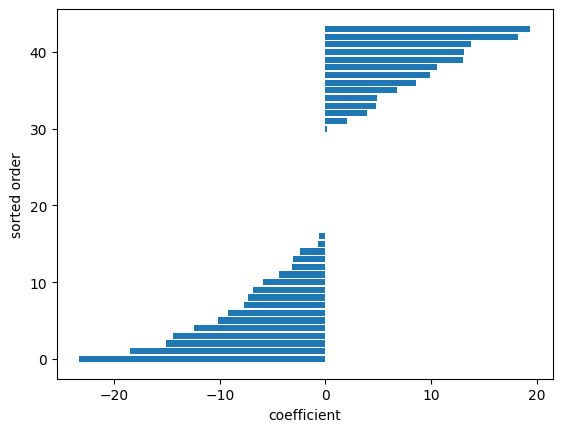

In [ ]:
plt.barh(range(len(lasso.coef_)), np.sort(lasso.coef_))
plt.xlabel('coefficient')
plt.ylabel('sorted order')

一部が大きい値になっている。

寄与の大きいtop10の特徴量とその係数を表示して見る。

In [ ]:
get_top10_feature_names(poly.powers_, attributes, lasso)

feature name : coefficient
--------------------------------------------------
(Displacement)**1 : -23.2824
(Displacement)**1 * (Model Year)**1 : 19.4147
(Weight)**1 * (Model Year)**1 : -18.5102
(Cylinders)**1 * (Weight)**1 : 18.2060
(Acceleration)**1 : -15.0481
(Weight)**1 : -14.4693
(Acceleration)**1 * (Model Year)**1 : 13.7492
(Cylinders)**1 * (Acceleration)**1 : 13.0941
(Acceleration)**1 * (Origin2)**1 : 13.0751
(Horsepower)**1 * (Origin3)**1 : -12.4082


Displacementが最も大きな寄与になるなど、様子が変わった。

## 4.2 LASSOモデルの選択

LASSOの正則化パラメータ$\alpha$に関してモデルを選択する。これはつまり、44個の多項式特徴量のうち**何個の特徴量を選択するのが一番良いか**、という特徴量選択を行うことに他ならない。なぜならばL1正則化の強さにより、残る特徴量の数は変わるからである。

In [ ]:
alphas = [2**i for i in range(-14,1)]

best_score = -np.inf # ベストなスコア。初期値はマイナス無限大にしておく
score_val_list = list()
best_model = None

for alpha in alphas:
    lasso = Lasso(max_iter=100000, alpha=alpha)
    lasso.fit(X_train_poly, y_train)
    score_val = lasso.score(X_val_poly, y_val)
    score_val_list.append(score_val)
    if best_score<score_val:
        best_score = score_val
        best_alpha = alpha
        best_model = lasso

print('best alpha:', best_alpha)

best alpha: 0.015625


$log_{2}\alpha$ごとの検証スコア

Text(0, 0.5, 'val score')

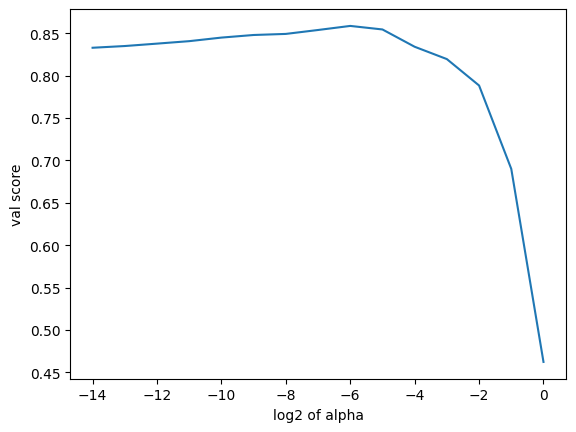

In [ ]:
plt.plot(np.log2(alphas), score_val_list)
plt.xlabel('log2 of alpha')
plt.ylabel('val score')

ベストモデルにおいてゼロになった係数の個数は、先ほどより増えれて

In [ ]:
np.sum(best_model.coef_==0)

29

ベスト検証スコアは

In [ ]:
best_score

0.8584967420813752

大きな係数を持つ特徴量トップ１０は

In [ ]:
get_top10_feature_names(poly.powers_, attributes, best_model)

feature name : coefficient
--------------------------------------------------
(Weight)**1 : -21.2152
(Model Year)**2 : 10.3291
(Weight)**2 : 7.6943
(Horsepower)**1 : -7.2701
(Weight)**1 * (Acceleration)**1 : -7.1186
(Weight)**1 * (Model Year)**1 : -4.5316
(Acceleration)**1 * (Origin3)**1 : 3.5388
(Displacement)**1 * (Weight)**1 : 3.5137
(Horsepower)**1 * (Model Year)**1 : -2.9773
(Acceleration)**1 * (Model Year)**1 : 2.7918


## 4.3 残差プロット

残差はゼロ周りに分布。しかしまだ改善の余地は残っている。
特に<b>分散の均一性</b>がまだ悪い。

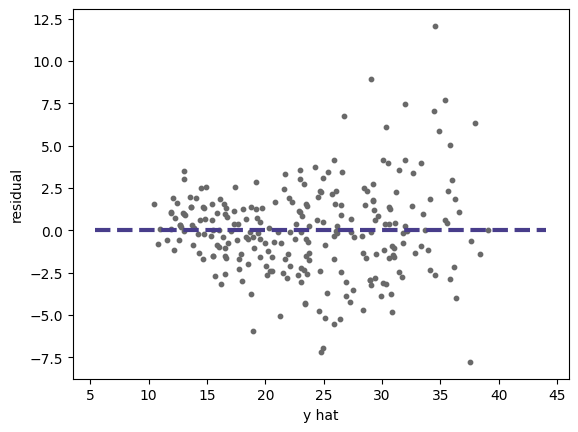

In [ ]:
y_hat = best_model.predict(X_train_poly)
residual = y_train-y_hat

plt.scatter(y_hat, residual, c='dimgray', s=10)
plt.hlines([0], np.min(y_hat)-5, np.max(y_hat)+5, 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel('y hat')
plt.ylabel('residual')
plt.show()

## テクニック

`train_test_split`の前に出力属性を`log`、あるいは一般にはBox-Cox変換

$$
y\to y' =
\left\{\begin{array}{1}
\frac{y^{\lambda}-1}{\lambda}\quad(\lambda\neq0) \\
\log y\quad(\lambda=0)
\end{array}\right.
$$

で変換しておくと、均一性が改善することがある($\lambda$はハイパーパラメータ)。SciPyでは
```python
scipy.stats.boxcox
```
`log`なので、引数の属性を正にしておかねばならないことに注意。

# 5 ベストなモデルのテスト評価

In [ ]:
X_test_scaled = scaler.transform(X_test)
X_test_poly = poly.transform(X_test_scaled)

print('test score:', best_model.score(X_test_poly, y_test))

test score: 0.8900910192723023




テスト二乗誤差は

In [ ]:
print('test mse:', np.mean((best_model.predict(X_test_poly)-y_test)**2))

test mse: 5.9094150299155945


ちなみにニューラルネットを使ったチュートリアルではもう少しだけ良い結果が得られます

https://www.tensorflow.org/tutorials/keras/regression?hl=ja

しかしニューラルネットを使わずとも、そんなに悪くない結果が得られますね！

# 6 重回帰のスクラッチ実装＊

単回帰の実装からほとんど変わらない。

In [ ]:
class MyLinearRegression():
    def __init__(self, eta0, n_iter):
        self.eta = eta0
        self.n_iter = n_iter

    def predict(self, x):
        y =  x @ self.a + self.b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @ (self.predict(X) - y[:,np.newaxis])
        return da

    def grad_b(self, X, y):
        db = 2*np.mean(self.predict(X) - y[:,np.newaxis])
        return db

    def fit(self, X, y):
        P = X.shape[1]
        self.a = 2 * np.random.rand(P,1) - 1.
        self.b = 2 * np.random.rand(1,1) - 1.
        for _ in range(self.n_iter):
            self.a, self.b  = self.a - self.eta*self.grad_a(X, y),\
                              self.b - self.eta*self.grad_b(X, y)
        return self

## テクニカルなコメント

前回からの仕様変更：

どんな`P`が来ても対応できるように、パラメータ（`a`のサイズは`P`で決まる）の初期化は`fit()`の中で行うようになった。
→ 代償に`fit`を繰り返し連続して行えなくなった（毎回初期化されてしまう）。

yはshape(N,)のベクトルのままで入力できるようになった。`.predict()`の返り値は(N,1)になることに注意。

動作確認して見る：

In [ ]:
reg = MyLinearRegression(eta0=0.01, n_iter=5000)

In [ ]:
y_train_array = np.array(y_train)
reg.fit(X_train_poly, y_train_array)

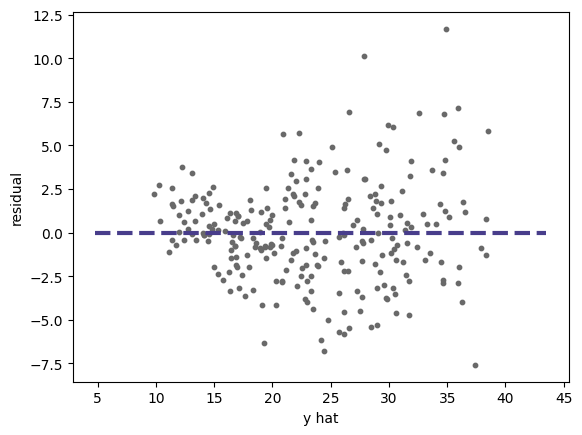

In [ ]:
y_hat = reg.predict(X_train_poly)
residual = y_train_array[:,np.newaxis]-y_hat

plt.scatter(y_hat, residual, c='dimgray', s=10)
plt.hlines([0], np.min(y_hat)-5, np.max(y_hat)+5, 'darkslateblue', linewidths=3, linestyles='dashed')
plt.xlabel('y hat')
plt.ylabel('residual')
plt.show()

# 7 オブジェクト指向とプライベート変数＊

オブジェクト指向言語としてのPythonの特徴的な点について、スクラッチ実装を題材に解説しましょう。ここで紹介する話はエンジニアにとっては一般常識の範疇ですので、将来コードを扱う仕事をするならばぜひ理解しましょう。

## 7.1 プライベート変数による「隠蔽」

オブジェクト指向言語の特徴は諸説ありますが、
その一つにカプセル化による隠蔽があります。

Pythonのクラスから作られたオブジェクトの属性（データ、フィールド）は、

In [ ]:
reg.a

array([[ 1.92919836],
       [-1.49455371],
       [-2.05877439],
       [-6.04055722],
       [ 5.56979581],
       [ 7.59728804],
       [ 2.67627039],
       [ 1.23893175],
       [-0.46500994],
       [ 0.53688904],
       [ 0.71522357],
       [ 0.47166288],
       [-2.06568605],
       [-1.48172691],
       [-1.77972424],
       [-0.03727244],
       [ 1.85960902],
       [ 0.89503152],
       [ 0.54138127],
       [-2.4236429 ],
       [-2.73842948],
       [-2.00703575],
       [-1.80910435],
       [-1.27055243],
       [-1.88795865],
       [-3.29556856],
       [-2.97999921],
       [-2.12162724],
       [-3.62021271],
       [-2.85149633],
       [-6.83810507],
       [-7.07630421],
       [-4.37735792],
       [-2.04725355],
       [-0.56050764],
       [ 1.4098621 ],
       [ 0.22610925],
       [ 3.83812917],
       [ 6.76586808],
       [ 1.0372173 ],
       [-1.01612709],
       [ 1.56778522],
       [-0.80553376],
       [ 0.49903788]])

という形で直接取得することができます。そればかりか

In [ ]:
reg.a = 0

というように書き換えてしまうこともできます。実際改めて同じ属性を見ると

In [ ]:
reg.a

0

と、外側から大事な属性が書き換えられてしまいます。この実装の問題点はscikitlearnと同じです。

そこで`a`や`b`は内部だけで使うもので、オブジェクトの外から操作させたくない時には`__a`、`__b`のようにダンダーをつけるのがPythonの仕様です：

In [ ]:
class MyLinearRegression():
    def __init__(self, eta0, n_iter):
        self.eta = eta0
        self.n_iter = n_iter

    def predict(self, x):
        y =  x @ self.__a + self.__b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @ (self.predict(X) - y[:,np.newaxis])
        return da

    def grad_b(self, X, y):
        db = 2*np.mean(self.predict(X) - y[:,np.newaxis])
        return db

    def fit(self, X, y):
        P = X.shape[1]
        self.__a = 2 * np.random.rand(P,1) - 1.
        self.__b = 2 * np.random.rand(1,1) - 1.
        for _ in range(self.n_iter):
            self.__a, self.__b  = self.__a - self.eta*self.grad_a(X, y),\
                                  self.__b - self.eta*self.grad_b(X, y)
        return self

In [ ]:
reg = MyLinearRegression(eta0=0.01, n_iter=5000)
reg.fit(X_train_scaled, y_train_array)

こうすると、ダンダーをつけた属性は外からアクセスできなくなります（正確なことは7.3参照）：

In [ ]:
reg.__a

AttributeError: 'MyLinearRegression' object has no attribute '__a'

`__a`は外からアクセスできないプライベートな変数になりました。これにより属性を誤って書き換える恐れがなくなりました。

## 7.2 セッター・ゲッターとプロパティー

先ほどのやり方では、属性を書き換えることを不可能にできましたが、同時に見ることもできなくなってしまいました。これでは不便です。そこでみることだけは可能にする方法を考えてみましょう。

そこで重みを見る専用の関数（ゲッター、getter）を定義してみましょう

In [ ]:
class MyLinearRegression():
    def __init__(self, eta0, n_iter):
        self.eta = eta0
        self.n_iter = n_iter

    def predict(self, x):
        y =  x @ self.__a + self.__b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @ (self.predict(X) - y[:,np.newaxis])
        return da

    def grad_b(self, X, y):
        db = 2*np.mean(self.predict(X) - y[:,np.newaxis])
        return db

    def fit(self, X, y):
        P = X.shape[1]
        self.__a = 2 * np.random.rand(P,1) - 1.
        self.__b = 2 * np.random.rand(1,1) - 1.
        for _ in range(self.n_iter):
            self.__a, self.__b  = self.__a - self.eta*self.grad_a(X, y),\
                                  self.__b - self.eta*self.grad_b(X, y)
        return self

    def get_a(self):
        return self.__a

    def get_b(self):
        return self.__b

In [ ]:
reg = MyLinearRegression(eta0=0.01, n_iter=5000)
reg.fit(X_train_scaled, y_train_array)

こうすると

In [ ]:
reg.__a

AttributeError: 'MyLinearRegression' object has no attribute '__a'

というやり方では属性にアクセスできないものの、ゲッターを通じて

In [ ]:
reg.get_a()

array([[ -1.36806104],
       [ -1.48874738],
       [ -1.48434033],
       [-14.06582876],
       [  1.86043006],
       [  9.92892884],
       [  2.59180136],
       [  2.34060295]])

により重みを見ることができます。

（データを`X_train_scaled`に変えたので変数が減っています。）

（他の言語を知っていると）このようなgetter（、setter）という発想が自然に見えるかもしれませんが、実際はPythonではこうはしません。getterの代わりにプロパティというものを用います：

In [ ]:
class MyLinearRegression():
    def __init__(self, eta0, n_iter):
        self.eta = eta0
        self.n_iter = n_iter

    def predict(self, x):
        y =  x @ self.__a + self.__b
        return y

    def grad_a(self, X, y):
        N = X.shape[0]
        da = 2/N * X.T @ (self.predict(X) - y[:,np.newaxis])
        return da

    def grad_b(self, X, y):
        db = 2*np.mean(self.predict(X) - y[:,np.newaxis])
        return db

    def fit(self, X, y):
        P = X.shape[1]
        self.__a = 2 * np.random.rand(P,1) - 1.
        self.__b = 2 * np.random.rand(1,1) - 1.
        for _ in range(self.n_iter):
            self.__a, self.__b  = self.__a - self.eta*self.grad_a(X, y),\
                                  self.__b - self.eta*self.grad_b(X, y)
        return self

    @property
    def a(self):
        return self.__a

    @property
    def b(self):
        return self.__b

In [ ]:
reg = MyLinearRegression(eta0=0.01, n_iter=5000)
reg.fit(X_train_scaled, y_train_array)

こうするとゲッターを使わなくても今まで通り

In [ ]:
reg.a

array([[ -1.32874652],
       [ -1.41677076],
       [ -1.61765998],
       [-14.01495954],
       [  1.92623659],
       [  9.93436051],
       [  2.61802629],
       [  2.37257889]])

とすることで値が見える一方、

In [ ]:
reg.a = 0

AttributeError: can't set attribute 'a'

のような書き換えは禁止されます。こちらの方がPythonicなコードです（https://www.oreilly.co.jp/books/9784873119175/）。
セッターについても同様なので調べてみてください。

## 7.3 Pythonにおける隠蔽

さてダンダーにしろプロパティにしろ、変数を完全に隠すことができるものではありません。dirを使って

In [ ]:
dir(reg)

['_MyLinearRegression__a',
 '_MyLinearRegression__b',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'a',
 'b',
 'eta',
 'fit',
 'grad_a',
 'grad_b',
 'n_iter',
 'predict']

とモデルの属性一覧を見てみてください。`a`がなくなった代わりに`_MyLinearRegression__a`という名前の修正された属性ができています。これによりうっかりミスにより大事な属性を変更する恐れがなくなった一方、この`_MyLinearRegression__a`属性には通常通りのアクセスができます。実際

In [ ]:
reg._MyLinearRegression__a = 0

とすれば、次のようになります：

In [ ]:
reg.a

0

ですので依然として書き換える余地は残されていることに注意です。

ぜひ人為的ミスの起こりにくい（フールプルーフされた）安全性の高いコードを書く習慣をつけてくださいね。

# <center>5/23 宿題</center>

## 問題１ (重回帰の練習)
今回説明した手法を使って、重回帰の練習をしましょう。まず自分で何らかのデータセットを用意します（webから回帰向きのデータを検索）。そして、そのデータの前処理、重回帰モデルの学習、モデルの改善、ベストなモデルの選択、テスト性能の評価までを一通り行い、得られた結果について考察を加えてください。LASSOだけではなく、Ridgeも試してみましょう。モデルの学習結果から、データに関する何らかの仮説が立てられたり洞察が得られるとベストです。



## 問題２ (多重共線性)＊

それぞれの属性間の相関を計算し、共線性が気になる程度かどうか調べてみよ。場合によっては変数を削除せよ。

また多重共線性についてはどうか？分散拡大要因VIFについて調べて、評価してみよ。

多重共線性の考慮を加えた上で重回帰分析を行い、結果について比較検討せよ。




## 問題３ (スクラッチ実装)＊
ミニバッチ学習の仕組みについて調べて、それを実装しなさい。上のスクラッチ実装のコードをベースにして構いません。その上で、ミニバッチ学習を実際に行い、その効果や特性について調べてみましょう。